In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from numpy.linalg import matrix_power
import copy

In [2]:
#GNEP governed by completely controllable dynamics
#given in time discrete form

In [3]:
A=np.array([[1,0],[1,1]])
B=np.eye(2)
x_ast=np.array([0,0])
nx=2
nu=2
Nu=2
sampling_rate=0.1 
N=10
C=np.asarray([0,0])

In [4]:
#parameters
alpha=0.
beta=10
gamma=0 #penality of control
b=1
def const(k):
    if k>0 and k<N:
        return 2
    else:
        return 1

In [5]:
from scipy.optimize import Bounds
bounds = Bounds(N*nu*[-b], (N)*nu*[b])

In [6]:
def endcond(u,x_iv):
    u=u.reshape((N,nu))
    x=x_iv
    for k in range(N):
        x=A@x+B@u[k] +C
    return x-x_ast

In [7]:
nx_p=nx//Nu
nu_p=nu//Nu
def ell(x,i,k):
    res=const(k)*0.5*np.dot(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p],x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p])
    return res

In [8]:
def inner_objective(u,x_iv,v):
    u=u.reshape((N,nu))
    v=v.reshape((N,nu))
   #input u in form (N,nu)
    su=0
    for i in range(Nu):
        x=x_iv
        contrl=copy.deepcopy(u)
        contrl[:,i]=v[:,i]      
        for k in range(N+1):
            su+= ell(x,i,k)
            if k <N:    
                x=A@x+B@contrl[k]+C 
    diff=u-v
    su+=beta*0.5*np.dot(diff.flatten(),diff.flatten())              
    return su

In [9]:
K=[ matrix_power(A,k)@B for k in range(N)]
def inner_objective_jac(u,x_iv,v):
    u=u.reshape((N,nu))
    v=v.reshape((N,nu))
    jac=np.zeros((N,nu))
    for i in range(Nu):
        x=x_iv
        control=copy.deepcopy(u)
        control[:,i]=v[:,i]
        for k in range(N+1):
            diff=const(k)*(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p])
            for n in range(0,k):
                jac[n,i]+=np.dot(diff,K[k-n-1][i*nx_p:i*nx_p+nx_p,i])
            if k <N:
                x=A@x+B@control[k]+C    
    jac+=beta*(v-u)
    return jac.reshape(-1)

In [10]:
def g(x_iv,u):
    obj= lambda v: inner_objective(u,x_iv,v)
    jac= lambda v: inner_objective_jac(u,x_iv,v)
    v_0=np.zeros(u.shape).flatten()
    
    solution=minimize(obj,v_0, method="L-BFGS-B",jac=jac,bounds=bounds)
    if not solution.success:
        print("inner",solution.message)
    return solution

In [11]:
def objective(x_iv,u):
    u=u.reshape((N,nu)) 
    sec=0
    sec=(1-alpha)*g(x_iv,u).fun
    
    first=0
    x=x_iv
    for k in range(N+1):
        for i in range(Nu):
            first+=ell(x,i,k)
        if k<N:        
            x=A@x+B@u[k]+C 
        
    return first-sec

In [12]:
def objective(x_iv,u):
    u=u.reshape((N,nu)) 
    sec=0
    sec=(1-alpha)*g(x_iv,u).fun
    
    first=0
    x=x_iv
    for k in range(N+1):
        for i in range(Nu):
            first+=ell(x,i,k)
        if k<N:        
            x=A@x+B@u[k]+C 
        
    return first-sec

In [13]:
K=[matrix_power(A,k)@B for k in range(N)]
def objective_jac(x_iv,u):  #only with respect to u
    u=u.reshape((N,nu))
    jac=np.zeros((N,nu))

    #part dependent on u only
    contrl=copy.deepcopy(u)
    x=copy.deepcopy(x_iv)
    for k in range(N+1):
        diff=const(k)*(x-x_ast).transpose()
        for n in range(0,k):
            jac[n,:]+=diff@K[k-n-1]
        if k <N:
            x=A@x+B@contrl[k]+C 
    #part dependent on u and v
    v=g(x_iv,u).x
    v=v.reshape((N,nu))
    for i in range(Nu):
        x=x_iv
        contrl=copy.deepcopy(u)
        contrl[:,i*nu_p:nu_p+i*nu_p]=v[:,i*nu_p:nu_p+i*nu_p]
        j=1-i
        for n in range(N+1):
            diff=const(n)*(x[i*nx_p:i*nx_p+nx_p]-x_ast[i*nx_p:i*nx_p+nx_p]).transpose()
            for k in range(0,n):
                jac[k,j*nu_p:nu_p+j*nu_p]+=-(1-alpha)*diff@K[n-k-1][i*nx_p:i*nx_p+nx_p,j*nu_p:nu_p+j*nu_p]
            if n<N:
                x=A@x+B@contrl[n]+C
    jac+=beta*(v-u)            
    return jac.reshape(-1)  

In [14]:
def addnoise(x,a):
    return x+np.random.uniform(low=-a,high=a, size=x.size)
def addnoise_fac(x,b):
    y=x
    for i in range(len(x)):
        y[i]=x[i]+np.random.uniform(low=-b*np.abs(x[i]),high=b*np.abs(x[i]))
    return y

In [15]:
maxIter=50 #iteration number for MPC
x_ivv=np.asarray([-10,20]) #inital value
noise=0.01 #noise
op={"maxiter":1e3} #parameter for optimization

In [18]:
#MPC loop
x_iv=x_ivv
u_0=np.zeros(N*nu)
u_star=[]
x_star=[]
V=[]      #optimal-value function
V_0=[]    #Lyapunov function
V_diff=[] #difference V_0 and V
x_Last=[] #state at end of lookahead horizon

#we also solve the problem while imposing end-constraints for comparison
x_Last_end=[]  #respective terminal state
u_diff=[]      #difference solution with and without end constraints
x_star.append(x_iv)
print("Lyapunov,", "optimal value,", 'optimal-value with EC,', "EC")
for i in range(maxIter):
    if i%10==0:
        print(i)
    obj= lambda u: objective(x_iv,u)
    jac= lambda u: objective_jac(x_iv,u)
    ec= lambda u: endcond(u,x_iv)
    end_cond={'type': "eq",'fun': ec}
    solution=minimize(obj,u_0,method="L-BFGS-B",jac=jac,bounds=bounds)
    #solve problem with end constraints for comparison
    solution_end=minimize(obj,u_0,method="SLSQP",jac=jac,constraints=end_cond,bounds=bounds)
    if not solution.success:
        print(i, solution.message, endcond(solution.x, x_iv))
        
    contrl=solution.x
    contrl=contrl.reshape((N,nu))
    contrl_end=solution_end.x
    contrl_end=contrl_end.reshape((N,nu))
    
    x_last=x_iv
    for k in range(N):
        x_last    =A@x_last +B@contrl[k]+C
    x_Last.append(x_last)  
    x_last_end=x_iv
    for k in range(N):
        x_last_end    =A@x_last_end +B@contrl_end[k]+C
    x_Last_end.append(x_last_end) 
 

    V.append(solution.fun)
    V_0.append(inner_objective(solution.x,x_iv,solution.x))
    print(V_0[-1], V[-1], solution_end.fun, np.sum(x_Last[-1]-x_ast))
    
   
    V_diff.append(np.abs(solution_end.fun-solution.fun))
    u_diff.append(np.linalg.norm(contrl-contrl_end))
    u_curr=solution.x.reshape((N,nu))[0]
    u_star.append(u_curr)
    
    x_iv=A@x_iv+B@u_curr+C
    x_iv=addnoise_fac(x_iv, noise)
  
    x_star.append(x_iv)

Lyapunov, optimal value, optimal-value with EC, EC
0
3364.5 0.0 2.7035071774985227 -25.0
3713.520539519843 4.547473508864641e-13 2.1664478029802012 -24.428729209173607
2 ABNORMAL_TERMINATION_IN_LNSRCH [  0.02581871 -22.94860329]
4020.0360971854248 7.23846810615214e-05 2.607292071914344 -22.9227845811444
4505.888465617659 3.9108272176235914e-11 1.5402549023947358 -22.10616937155147
4867.715888400936 4.361936589702964e-09 0.687009340908844 -21.13570067273301
5183.421503267445 5.488863280334044e-06 1.2762371479893773 -20.388802277797666
5294.587810833896 2.2372540115611628e-05 4.947753692605147 -19.472773317258653
5108.236246860776 0.0005707097125196015 14.216142489877711 -18.165842130979705
4791.953196414134 0.0015983467828846187 29.77207056176121 -16.930354376314828
4566.643041260631 1.4552007996826433e-05 27.92638058509783 -16.23560015178679
10
4174.070014685515 4.8481761041330174e-05 20.463879635652575 -15.237590371966872
3812.3123922771388 0.00033008097398123937 17.800333874089574 -1

In [19]:
import os
dictname="easy dynamics/zero/"
os.makedirs(dictname)

In [20]:
with open(dictname+"/stats.txt", "w") as file:
    file.write("alpha="+str(alpha))
    file.write("\n")
    file.write("inital value="+str(x_ivv))
    file.write("\n")
    file.write("N="+str(N))
    file.write("\n")
    file.write("noise="+str(noise))
    file.write("\n")
    file.write("U=["+str(-b)+","+str(b)+"]")
    file.write("\n")
    file.write("gamma="+str(gamma))
    file.write("\n")
    file.write("beta="+str(beta))

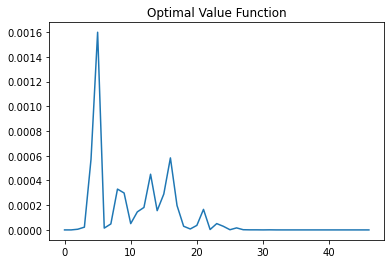

In [21]:
plt.plot(V[3:])
plt.title('Optimal Value Function')
plt.savefig("./"+dictname+"/optimalvalue.svg")

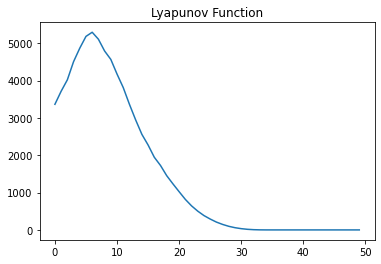

In [22]:
plt.plot(V_0)
plt.title('Lyapunov Function')
plt.savefig("./"+dictname+"/lyapunov.svg")

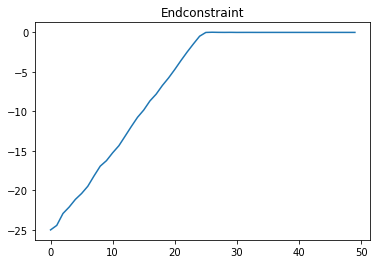

In [24]:
X_Last=[x-x_ast for x in x_Last]
X_Last=np.asarray(X_Last)
plt.plot(np.sum(X_Last, axis=1))
plt.title("Endconstraint")
plt.savefig("./"+dictname+"/endcond.svg")

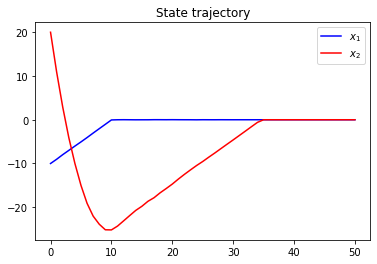

In [25]:
X_star=np.asarray(x_star)

plt.plot(X_star[:,0],"blue", label=r"$x_1$")
plt.plot(X_star[:,1],"red", label=r"$x_2$")
plt.legend()
plt.title("State trajectory")
plt.savefig("./"+dictname+"/state.svg")

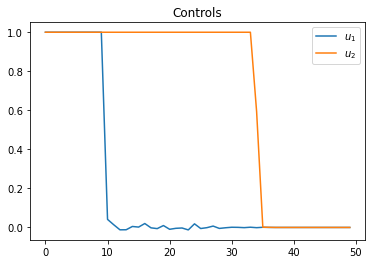

In [26]:
U_star=np.asarray(u_star)
plt.plot(U_star[:,0], label=r"$u_1$")
plt.plot(U_star[:,1],label=r"$u_2$")
plt.legend()
plt.title('Controls')
plt.savefig("./"+dictname+"/controls.svg")

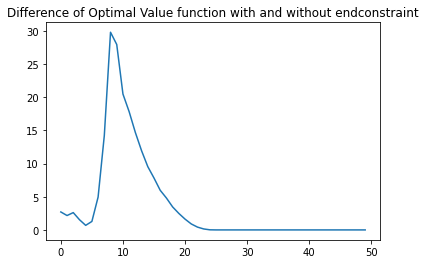

In [27]:
plt.plot(V_diff)
plt.title('Difference of Optimal Value function with and without endconstraint')
plt.savefig("./"+dictname+"/optimalvalue_diff.svg")

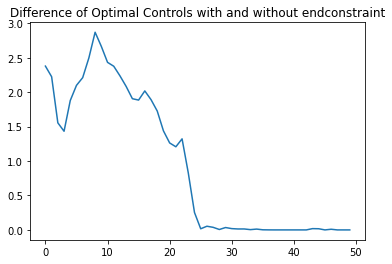

In [28]:
plt.plot(u_diff)
plt.title('Difference of Optimal Controls with and without endconstraint')
plt.savefig("./"+dictname+"/optimal_control_diff.svg")